In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import string
from nltk.corpus import stopwords
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Question #1

In [2]:
path_to_file = r"gender-classifier-DFE-791531.csv"

loaded_tweets = pd.read_csv(path_to_file, encoding='latin-1')

genders = {'female', 'male', 'brand'}
clean_loaded_tweets = loaded_tweets.loc[loaded_tweets['gender'].isin(genders)]

clean_loaded_tweets.loc[loaded_tweets['text'].isnull(), 'text'] = "-"
clean_loaded_tweets.loc[loaded_tweets['description'].isnull(), 'description'] = "-"

tweets = clean_loaded_tweets["text"].map(str) + " " + clean_loaded_tweets["description"]

#### Loaded Tweets by Gender

In [3]:
print(loaded_tweets["gender"].value_counts())

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64


#### Cleaned loaded Tweets by Gender

In [4]:
print(clean_loaded_tweets["gender"].value_counts())

female    6700
male      6194
brand     5942
Name: gender, dtype: int64


In [5]:
punctuation = list(string.punctuation)
stop_words = set(stopwords.words('english') + punctuation + list("__"))

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]

tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)


def tokenize(text):
    tokenized_clean_text = []
    text = re.sub(r'[^\x00-\x7f]*', r'', text)
    tokens = tokens_re.findall(text)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    for token in tokens:
        if token in stop_words:
            continue
        tokenized_clean_text.append(token)
    return tokenized_clean_text

#### Tokenizing cleaned tweets

In [6]:
tokenized_tweets = []

for tweet in tweets:
    if isinstance(tweet, str):
        tokenized_tweet = tokenize(tweet)
        tokenized_tweets.append(tokenized_tweet)
        
gender_column = clean_loaded_tweets["gender"]
counter = Counter(gender_column)
genders = counter.keys()
tweet_amount = counter.values()

#### Plot distribution of data

Tweet Distributions By Gender


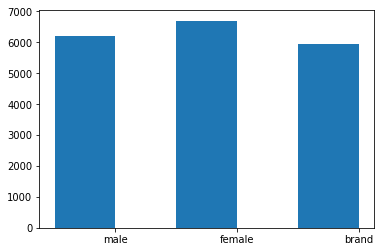

In [7]:
indexes = np.arange(len(genders))
plt.bar(indexes, tweet_amount, 0.5)
plt.xticks(indexes + 0.5 * 0.5, genders)
print('Tweet Distributions By Gender')
plt.show()

In [8]:
def get_gender_most_common_terms(terms,top):
    res = []
    counter = Counter()
    for term in terms:
        res.extend([token for token in tokenize(term)])
    counter.update(res)
    return counter.most_common(top)

#### Get most common terms by gender

In [9]:
top_amount = 40

for gender in genders:
    gender_most_common_terms=get_gender_most_common_terms(loaded_tweets.loc[loaded_tweets['gender'] == gender]['text'],top_amount)
    gender_most_common_terms=pd.DataFrame(gender_most_common_terms, columns=['Term', 'Count'])
    print(str.upper(gender[0])+ gender[1:]+ ' Most Common Terms\n')
    print(gender_most_common_terms)
    print('-'*100)


Male Most Common Terms

      Term  Count
0     like    352
1      get    346
2      one    267
3     time    232
4      new    216
5     love    209
6       go    205
7   people    197
8     good    186
9      day    186
10    know    184
11     see    168
12     got    159
13       2    159
14    back    157
15   think    157
16   would    154
17    best    152
18     amp    152
19    make    149
20   still    144
21    last    144
22      __    137
23    need    136
24    want    135
25       1    120
26     way    118
27  really    117
28   great    116
29     lol    113
30    game    113
31    year    110
32    well    109
33     via    108
34   going    108
35       u    107
36   world    103
37      im    102
38    much    102
39   first    101
----------------------------------------------------------------------------------------------------
Female Most Common Terms

      Term  Count
0     like    451
1      get    353
2       __    333
3      one    332
4     love    315
5  

# Question #2

In [10]:
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import json
import keras.preprocessing.text as kpt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [11]:
text_list=[''.join([token + " " for token in tweet]) for tweet in tokenized_tweets ]
test_ratio=0.2
X_train, X_test, y_train, y_test = train_test_split(text_list, gender_column, test_size=test_ratio, shuffle=False)

tf_idf_vectorizer = TfidfVectorizer()
X_train_vectorized = tf_idf_vectorizer.fit_transform(X_train)
X_test_vectorized = tf_idf_vectorizer.transform(X_test)

term_cap = 5000
tokenizer = Tokenizer(num_words=term_cap)
tokenizer.fit_on_texts(text_list)
term_dictionary= tokenizer.word_index

with open('dictionary.json', 'w') as dictionary_file:
    json.dump(term_dictionary, dictionary_file)

In [12]:
def words_to_indices(txt):
    return [term_dictionary[word] for word in kpt.text_to_word_sequence(txt)]

In [13]:
words_to_indices_train = [words_to_indices(text) for text in X_train]
words_to_indices_test=[words_to_indices(text) for text in X_test]

words_to_indices_train = np.asarray(words_to_indices_train)
words_to_indices_test = np.asarray(words_to_indices_test)

X_train_tokenized_matrix = tokenizer.sequences_to_matrix(words_to_indices_train, mode='binary')
X_test_tokenized_matrix = tokenizer.sequences_to_matrix(words_to_indices_test, mode='binary')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

### Keras

#### To prevent overfitting, we're using Dropout on hidden layers
For more information, please refer to this article:
https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [14]:
y_train_categorical_matrix = keras.utils.to_categorical(y_train_encoded, 3)
y_test_categorical_matrix = keras.utils.to_categorical(y_test_encoded, 3)

In [15]:
model = Sequential()
model.add(Dense(int(term_cap/2), input_shape=(term_cap,), activation='linear', name='layer_1'))
model.add(Dropout(0.5, name='layer_2'))
model.add(Dense(int(term_cap/4), activation='sigmoid', name='layer_3'))
model.add(Dropout(0.5, name='layer_4'))
model.add(Dense(len(genders), activation='softmax', name='layer_5'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 2500)              12502500  
_________________________________________________________________
layer_2 (Dropout)            (None, 2500)              0         
_________________________________________________________________
layer_3 (Dense)              (None, 1250)              3126250   
_________________________________________________________________
layer_4 (Dropout)            (None, 1250)              0         
_________________________________________________________________
layer_5 (Dense)              (None, 3)                 3753      
Total params: 15,632,503
Trainable params: 15,632,503
Non-trainable params: 0
_________

#### Training Keras

In [16]:
print("Training Keras")
print('-'*20)

batch = 64
num_iterations = 3
visible = 1

model.fit(X_train_tokenized_matrix, y_train_categorical_matrix,
  batch_size = batch,
  epochs = num_iterations,
  verbose = visible,
  validation_data = (X_test_tokenized_matrix, y_test_categorical_matrix), shuffle = True)

print("Testing Keras")
scores = model.evaluate(X_test_tokenized_matrix, y_test_categorical_matrix, verbose = 1)

Training Keras
--------------------
Instructions for updating:
Use tf.cast instead.
Train on 15068 samples, validate on 3768 samples
Epoch 1/3
15068/15068 [==============================] - 120s 8ms/step - loss: 0.9585 - acc: 0.5548 - val_loss: 0.9121 - val_acc: 0.5839
Epoch 2/3
15068/15068 [==============================] - 117s 8ms/step - loss: 0.7134 - acc: 0.6872 - val_loss: 0.9469 - val_acc: 0.5804
Epoch 3/3
15068/15068 [==============================] - 124s 8ms/step - loss: 0.6267 - acc: 0.7278 - val_loss: 0.9847 - val_acc: 0.5833
Testing Keras
3768/3768 [==============================] - 5s 1ms/step


In [17]:
print("Params: batch_size = "+str(batch)+"\tepochs = "+str(num_iterations))
print("Model Accuracy %.2f" % (scores[1]*100))

Params: batch_size = 64	epochs = 3
Model Accuracy 58.33


In [18]:
#with open('model.json', 'w') as json_file:
#    json_file.write(model.to_json())
weights_file_name = 'modelWeights'
model.save_weights(weights_file_name+'.h5')

#### Classifiers: SVN and K-Nearest Neighbors

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn import metrics

#### Classifier train and test function

In [20]:
def test_classifier(classifier,classifier_name, X_train, X_test):
    #Train
    print("Training "+classifier_name)
    print('-'*20)
    classifier.fit(X_train, y_train)

    #Test 
    print("Testing "+classifier_name)
    pred = classifier.predict(X_test)

    #Accuracy Evaluation
    accuracy = metrics.accuracy_score(y_test, pred)

    print("Accuracy: %.2f" % accuracy)
    print()

In [21]:
results_tfidf = []
classifiers = [(SGDClassifier(), "SVM"),(KNeighborsClassifier(), "K-Nearest Neighbors")]

for classifier, classifier_name in classifiers:
    test_classifier(classifier,classifier_name, X_train_vectorized, X_test_vectorized)

Training SVM
--------------------
Testing SVM
Accuracy: 0.60

Training K-Nearest Neighbors
--------------------
Testing K-Nearest Neighbors
Accuracy: 0.50



# Question #3

#### Find most common country - US & Canada

In [22]:
tweet_location_train, tweet_location_test = train_test_split(clean_loaded_tweets["user_timezone"], 
                                                           test_size=0.30, 
                                                           shuffle = False)
tweet_location_train = tweet_location_train.dropna()

counter = Counter()
counter.update(tweet_location_train)
print(counter.most_common(1))

[('Eastern Time (US & Canada)', 1667)]


### Twitter Mining

In [23]:
import tweepy
from tweepy import OAuthHandler

## OAuth

In [24]:
def authenticate(consumer_key,
                 consumer_secret, 
                 access_token, 
                 access_secret):
    
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return tweepy.API(auth, wait_on_rate_limit = True)

In [25]:
api = authenticate('xGmH3k9cREZ4hpnjsYQtIQ5um',
                  '25bBLLue9d9LT8RySWTTG4dwvn0iEbymwpvgfvUtsopghkLVrL',
                  '2827486724-433UvU84r38VPaAbmqyzT95MvjHUIcB25NUZYQ7',
                  'GuGv8nwmVEv8u3ItlpYNwxoO5HOzAseic6RlgETXffd71')


In [26]:
tweets_file_name = 'tweetsFromAPI'

### Define Custom StreamListener

#### Saves the tweeets to file by batch downloading

In [27]:
class TweetStreamListener(tweepy.StreamListener):
    
    def __init__(self, api=None):
        super(TweetStreamListener, self).__init__()
        self.num_tweets = 0

    def on_data(self, data):
        if self.num_tweets < 15000:
                try:
                    with open(tweets_file_name+'.json', 'a') as tweet_file:
                        tweet_file.write(data)
                        self.num_tweets += 1
                        return True
                except BaseException as e:
                    print("Error on_data: " + str(e))
                    return True
        else:
            return False

    def on_error(self, status):
        print("Error: "+status)
        return True

In [28]:
#tweet_listener = TweetStreamListener()
#tweet_stream = tweepy.Stream(auth=api.auth, listener=tweet_listener)
#tweet_stream.filter(locations=[-162.8,28.2,-64.4,71.6])

#### Read tweets from file

In [29]:
tweet_file = open(tweets_file_name+'.json', "r")

loaded_tweets = []
for jsonStr in tweet_file:
    try:
        tweet = json.loads(jsonStr)
        loaded_tweets.append(tweet['text'])
    except:
        continue

#### Pre-Proccess the tweets

In [30]:
proccessed_tweets = []
for loaded_tweet in loaded_tweets:
    text = ""
    for token in tokenize(loaded_tweet):
        text += token + " "
    proccessed_tweets.append(text)

#### Get term count from downloaded tweets

In [31]:
data = get_gender_most_common_terms(proccessed_tweets, top_amount)
term_df = pd.DataFrame(data, columns = ['Term','Frequency'])

print(term_df)

      Term  Frequency
0     like        929
1      job        736
2       im        563
3      get        480
4      see        480
5     time        387
6      one        363
7      amp        360
8      new        333
9     link        331
10      go        328
11    good        325
12   click        323
13    love        322
14   great        321
15     day        321
16    want        307
17     bio        299
18    know        297
19  people        293
20    work        293
21     lol        288
22     got        281
23    dont        276
24      us        268
25   apply        259
26   today        251
27    back        229
28  latest        225
29   going        225
30  really        223
31       3        209
32    need        208
33   would        202
34  hiring        193
35   think        191
36    make        190
37    even        189
38    jobs        188
39       2        182


#### Tokenize the terms

In [32]:
tokenizer = Tokenizer(num_words=term_cap)

## Question #4

In [33]:
def textToArr(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in term_dictionary:
            wordIndices.append(term_dictionary[word])
    return wordIndices

#### Predict the gender of the downloaded tweets

In [34]:
genders = ['brand', 'female', 'male']
prediction_df=pd.DataFrame(columns=['Tweet ID','Predicted Gender'])
index=0
for tweet in proccessed_tweets:
    testArr = textToArr(tweet)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    pred = model.predict(input)
    data = tweet + "," + str(genders[np.argmax(pred)]) + "," + str(pred[0][np.argmax(pred)] * 100) + '\n'
    pred_gender= str(genders[np.argmax(pred)])
    prediction_df = prediction_df.append({'Tweet ID': index, 'Predicted Gender': pred_gender}, ignore_index=True)

In [35]:
print(prediction_df)

      Tweet ID Predicted Gender
0            0           female
1            0           female
2            0           female
3            0            brand
4            0           female
5            0            brand
6            0           female
7            0           female
8            0           female
9            0           female
10           0            brand
11           0           female
12           0           female
13           0           female
14           0             male
15           0             male
16           0           female
17           0            brand
18           0             male
19           0            brand
20           0           female
21           0           female
22           0           female
23           0            brand
24           0             male
25           0             male
26           0           female
27           0             male
28           0           female
29           0           female
...     

In [36]:
prediction_df["Predicted Gender"].value_counts()

female    7687
male      5255
brand     2058
Name: Predicted Gender, dtype: int64

In [37]:
from genderize import Genderize

tweet_file = open(tweets_file_name+'.json', "r")
tweets_id_name_dict = dict()
a=0
for jsonStr in tweet_file:
    try:
        tweet = json.loads(jsonStr)
        tweets_id_name_dict[tweet['id']]=tweet['user']['name']
        a=a+1
        if a> 1000:
            break
    except:
        continue

In [38]:
names = set([tweets_id_name_dict[id].split()[0] for id in tweets_id_name_dict])
#print(tweets_id_name_dict)

#### To determine the accuracy of our model on the downloaded tweets, we compare our predicted gender to a prediction of another source - the Genderize API - more on the API at https://genderize.io/
This API is throwing an exception if the request rate is too high, so to avoid technical problems we downloaded the most accurate predicitons (above 80%) to a csv.
The purpose of using this data is to compare our data to our models predictions and help us determine its accuracy for predicting the gender for live tweets.

In [39]:
#names set, in order to use only distinct values
genderizer = Genderize(timeout = 5.0)

path_to_genderized_file = 'name_gender.csv'
try:
    names_gender = genderizer.get(names)
    names_gender.to_csv(path_to_genderized_file)
except:
    names_gender = pd.read_csv(path_to_genderized_file, encoding='latin-1')

In [40]:
print(names_gender)

     count  gender            name  probability
0    381.0    male         Ernesto         1.00
1   4440.0  female            mary         1.00
2   2925.0    male            Jeff         1.00
3    167.0    male            Gabe         0.97
4      1.0  female         sodapop         1.00
5      1.0  female            Mama         1.00
6    576.0  female         Caitlin         1.00
7    929.0    male            Carl         1.00
8   3821.0    male            Jose         0.99
9    611.0    male         Douglas         1.00
10    16.0    male            Trev         1.00
11     1.0  female             The         1.00
12  2787.0  female          Monica         1.00
13  1233.0  female             Jen         0.99
14   954.0    male           Colin         0.99
15     1.0  female        Jessmine         1.00
16  1799.0  female         Shannon         0.93
17  2262.0    male             Rob         0.99
18    83.0    male          mohsen         1.00
19   710.0    male            Drew      

In [41]:
for id in tweets_id_name_dict:
    tweet_name = tweets_id_name_dict[id].split()[0]
    genderized_gender = names_gender.loc[names_gender['name'] == tweet_name]['gender']

In [42]:
#print(prediction_df)